# Approximate Rates

pynucastro can use rate approximations for $A(\alpha,\gamma)B$ and $A(\alpha,p)X(p,\gamma)B$,
combining them into a single effective rate by assuming that the protons and nucleus $X$ are in equilibrium.

In [1]:
import pynucastro as pyna
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

Let's create a simple network that has both an $(\alpha, \gamma)$ and
$(\alpha, p)(p, \gamma)$ sequence.

In [2]:
reaclib_library = pyna.ReacLibLibrary()
mylib = reaclib_library.linking_nuclei(["mg24", "al27", "si28", "p31", "s32", "he4", "p"])
pynet = pyna.PythonNetwork(libraries=[mylib])

TypeError: argument of type 'NoneType' is not iterable

In [3]:
fig = pynet.plot(rotated=True, curved_edges=True)

NameError: name 'pynet' is not defined

In [4]:
pynet.write_network("full_net.py")

NameError: name 'pynet' is not defined

In [5]:
import full_net

ModuleNotFoundError: No module named 'full_net'

## Integrating the full network

Now let's integrate this.  We'll start with half ${}^{24}\mathrm{Mg}$ and half $\alpha$ by mass.

In [6]:
rho = 1.e7
T = 3e9

X0 = np.zeros(full_net.nnuc)
X0[full_net.jhe4] = 0.5
X0[full_net.jmg24] = 0.5

Y0 = X0 / full_net.A

NameError: name 'full_net' is not defined

In [7]:
tmax = 1.e-3
sol = solve_ivp(full_net.rhs, [0, tmax], Y0, method="BDF",
                dense_output=True, args=(rho, T), rtol=1.e-6, atol=1.e-10)

NameError: name 'full_net' is not defined

NameError: name 'full_net' is not defined

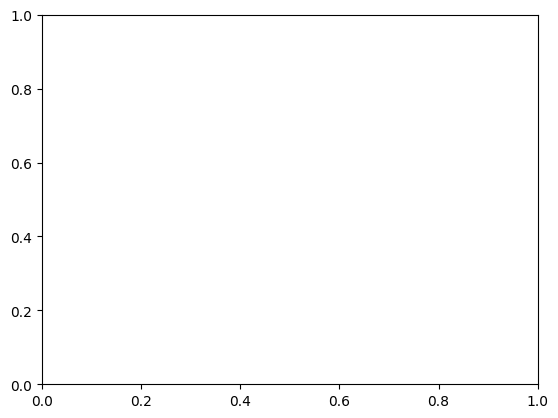

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(full_net.nnuc):
    ax.loglog(sol.t, sol.y[i,:] * full_net.A[i], label=f"X({full_net.names[i].capitalize()})")

ax.legend()

ax.set_xlim(1.e-10, 1.e-3)
ax.set_ylim(1.e-12, 1)
fig.set_size_inches((10, 8))

## Approximate Version

Now we will approximate the rates, combining $(\alpha, \gamma)$ and
$(\alpha, p)(p, \gamma)$ into a single effective rate.

The routine `make_ap_pg_approx()` will find all of the rates that make up that sequence and create a
single `ApproximateRate` that captures the effective rate.  The original rates will still be stored in the `ApproximateRate` object and will be evaluated to compute the needed approximation when the effective rate is evaluated.

In [9]:
pynet.make_ap_pg_approx()

NameError: name 'pynet' is not defined

In [10]:
pynet

NameError: name 'pynet' is not defined

Since we no longer care about the ${}^{27}\mathrm{Al}$ and ${}^{31}\mathrm{P}$, we can remove them from the network.  The `ApproximateRate` object still knows that these are the intermediate nucleus, but now they
won't explicitly appear as one of the nuclei in the network.

In [11]:
pynet.remove_nuclei(["al27", "p31"])

NameError: name 'pynet' is not defined

Note that since no reactions consume protons after that removal, the protons are all removed from the network, reducing its size from 7 nuclei to 4

In [12]:
print(pynet.network_overview())

NameError: name 'pynet' is not defined

In [13]:
fig = pynet.plot(rotated=True, curved_edges=True)

NameError: name 'pynet' is not defined

As we see above, the nuclei ${}^{27}\mathrm{Al}$ and ${}^{31}\mathrm{P}$ no longer appear in the network, but  the links to them are still understood to the network.  This reduces the size of the network, while still preserving those flows.

In [14]:
pynet.write_network("approx_net.py")

NameError: name 'pynet' is not defined

In [15]:
import approx_net

ModuleNotFoundError: No module named 'approx_net'

The `PythonNetwork` knows how to write out the code needed to evaluate the rate approximation.  For instance, the evolution of ${}^{4}\mathrm{He}$ is determined as:

In [16]:
print(pynet.full_ydot_string(pyna.Nucleus("he4")))

NameError: name 'pynet' is not defined

And the rate approximations are computed as:

In [17]:
r = pynet.get_rate("mg24_he4__si28__approx")
print(r.function_string_py())

NameError: name 'pynet' is not defined

where the 4 lines before the rate approximation is made are evaluating the original, unapproximated rates.

## Integrating the approximate network

Let's integrate this approximate net and compare to above

In [18]:
rho = 1.e7
T = 3.e9

X0 = np.zeros(approx_net.nnuc)
X0[approx_net.jhe4] = 0.5
X0[approx_net.jmg24] = 0.5

Y0 = X0 / approx_net.A

NameError: name 'approx_net' is not defined

In [19]:
tmax = 1.e-3
approx_sol = solve_ivp(approx_net.rhs, [0, tmax], Y0, method="BDF",
                       dense_output=True, args=(rho, T), rtol=1.e-6, atol=1.e-10)

NameError: name 'approx_net' is not defined

NameError: name 'approx_net' is not defined

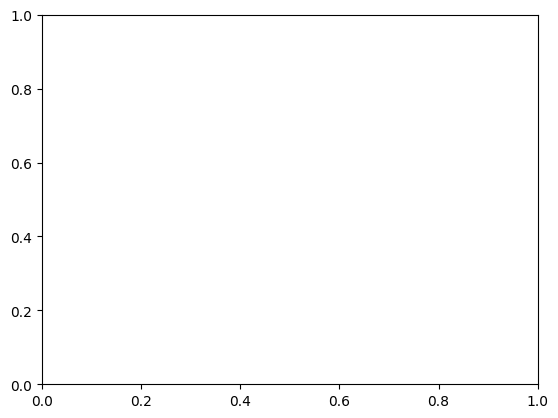

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(approx_net.nnuc):
    ax.loglog(approx_sol.t, approx_sol.y[i,:] * approx_net.A[i], label=f"X({approx_net.names[i].capitalize()})")

ax.legend()
ax.set_xlim(1.e-10, 1.e-3)
ax.set_ylim(1.e-12, 1)

fig.set_size_inches((10, 8))

## Comparison

Let's plot both on the same axes to see the comparison.

NameError: name 'approx_net' is not defined

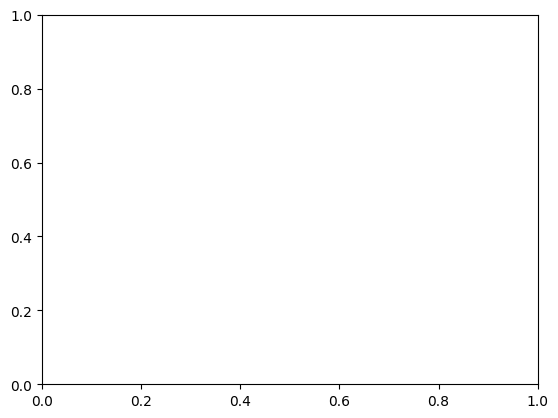

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(approx_net.nnuc):
    ax.loglog(approx_sol.t, approx_sol.y[i,:] * approx_net.A[i],
              linestyle=":", color=f"C{i}")

    idx = full_net.names.index(approx_net.names[i])
    ax.loglog(sol.t, sol.y[idx,:] * full_net.A[idx],
              label=f"X({full_net.names[idx].capitalize()})",              
              linestyle="-", color=f"C{i}")


ax.legend()
ax.set_xlim(1.e-10, 1.e-3)
ax.set_ylim(1.e-12, 1)

fig.set_size_inches((10, 8))

Here the dotted line is the approximate network.  We see that the results agree well.

## No approximation

What if we just create a 4 nuclei network without the $(\alpha,p)(p,\gamma)$ links?  How does this compare?

In [22]:
newlib = reaclib_library.linking_nuclei(["he4", "mg24", "si28", "s32"])
newpynet = pyna.PythonNetwork(libraries=[newlib])
fig = newpynet.plot(rotated=True, curved_edges=True)

NameError: name 'reaclib_library' is not defined

In [23]:
newpynet.write_network("simple_net.py")
import simple_net

NameError: name 'newpynet' is not defined

In [24]:
rho = 1.e7
T = 3e9

X0 = np.zeros(simple_net.nnuc)
X0[simple_net.jhe4] = 0.5
X0[simple_net.jmg24] = 0.5

Y0 = X0 / simple_net.A

NameError: name 'simple_net' is not defined

In [25]:
simple_net.names == approx_net.names

NameError: name 'simple_net' is not defined

In [26]:
tmax = 1.e-3
simple_sol = solve_ivp(simple_net.rhs, [0, tmax], Y0, method="BDF",
                       dense_output=True, args=(rho, T), rtol=1.e-6, atol=1.e-10)

NameError: name 'simple_net' is not defined

NameError: name 'approx_net' is not defined

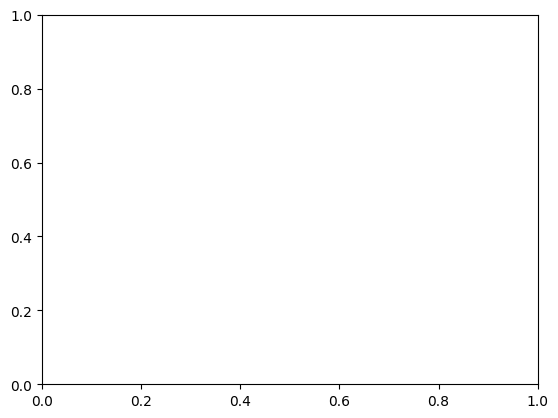

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(approx_net.nnuc):
    ax.loglog(approx_sol.t, approx_sol.y[i,:] * approx_net.A[i],
              linestyle=":", color=f"C{i}")

    idx = full_net.names.index(approx_net.names[i])
    ax.loglog(sol.t, sol.y[idx,:] * full_net.A[idx],
              label=f"X({full_net.names[idx].capitalize()})",              
              linestyle="-", color=f"C{i}")

    idx = simple_net.names.index(approx_net.names[i])
    ax.loglog(simple_sol.t, simple_sol.y[idx,:] * simple_net.A[idx],
              linestyle="--", color=f"C{i}")


ax.legend()
ax.set_xlim(1.e-10, 1.e-3)
ax.set_ylim(1.e-12, 1)

fig.set_size_inches((10, 8))

Here we see all 3 networks.  The full network (7 nuclei) is the solid lines.  The approximate version of that is the dotted line.  We see that they track reasonably well, especially when the abundance is high.  The dashed line is the version of the network that has the same 4 nuclei as the approximate network, but with out approximating the $(\alpha, p)(p,\gamma)$ links, so we see that the ${}^{24}\mathrm{Mg}$ takes longer to burn.